<div><img src="blob/structure.jpg" width=400px float="left"/></div>

# SVG to Text with CNN and Transformer

In [1]:
import io
import os
import math
import numpy as np
import random

import matplotlib.pyplot as plt
from IPython.display import clear_output
# from cairosvg import svg2png
from IPython.display import SVG, display
import svgwrite
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split

from model import *
import svg_converter as converter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cpu'

### Preprocessing

In [3]:
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

def names_to_file(fn_tok_path, folder_path):
    with open(fn_tok_path, 'w') as f:
        filenames = []

        for root, _, files in os.walk(folder_path):
            for file in files:
                filename, extension = os.path.splitext(file)
                if extension == '.svg':
                    filenames.append(filename)

        for line in filenames:
            _, filename = line.strip().split('_')
            filename = filename.replace('-', ' ')
            f.write(tokenize(filename) + "\n")

def get_svg_paths(folders):
    svg_paths = []

    for i, folder in enumerate(folders):
        files = [file for file in os.listdir(folder)]

        for file in files:
            svg_name = file[:-4] # del ".svg"
            svg_name = svg_name.strip().split('_')

            if len(svg_name) > 1:
                svg_name = svg_name[1]
            else:
                svg_name = svg_name[0]
                
            svg_name = svg_name.replace('-', ' ')
            svg_name = tokenize(svg_name)
            svg_name = filenames_bpe.process_line(svg_name)

            svg_path = os.path.join(folder, file)

            svg_paths.append([svg_name, svg_path])

    return svg_paths

In [4]:
dataset_path = 'dataset'
tokenizer = WordPunctTokenizer()

In [5]:
# fn_tok_path = 'dataset/filenames_tokenized.txt'
# names_to_file(fn_tok_path, dataset_path)
# learn_bpe(open(fn_tok_path), open('bpe_rules.fnt', 'w'),  num_symbols=2000)

In [7]:
filenames_bpe = BPE(open('checkpoints/bpe_rules_model_0.1.fnt'))

In [8]:
folders = os.listdir(dataset_path)
folders = [os.path.join(dataset_path, foldername)
           for foldername in folders
           if os.path.isdir(os.path.join(dataset_path, foldername))]

print(len(folders))

all_svg_paths = np.array(get_svg_paths(folders[:2500]))

5266


In [9]:
len(all_svg_paths), all_svg_paths[:5]

(149693,
 array([['fre@@ e@@ do@@ m',
         'dataset/4111_womens-day-2/244552_freedom.svg'],
        ['equ@@ ality g@@ ender',
         'dataset/4111_womens-day-2/244545_equality-gender.svg'],
        ['a@@ chi@@ e@@ ve@@ ment mountain',
         'dataset/4111_womens-day-2/244542_achievement-mountain.svg'],
        ['educ@@ ation col@@ le@@ ge',
         'dataset/4111_womens-day-2/244551_education-college.svg'],
        ['stop vi@@ o@@ l@@ ence woman',
         'dataset/4111_womens-day-2/244556_stop-violence-woman.svg']],
       dtype='<U180'))

In [10]:
train_paths, test_paths = train_test_split(
    all_svg_paths,
    test_size=0.2,
    random_state=42,
)

In [11]:
len(train_paths), len(test_paths), train_paths[0]

(119754,
 29939,
 array(['apple sof@@ tw@@ are user interface',
        'dataset/5282_solid-line-icons/304411_apple-software-user-interface.svg'],
       dtype='<U180'))

In [12]:
# voc = Vocab.from_lines(all_svg_names)
# len(voc)

### Train

In [13]:
batch_size = 16
seq_len = 512
src_pad_token = torch.tensor([0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  1.0000])

c = converter.Converter(seq_len)

train_dataset = SvgDataset(train_paths, seq_len=seq_len, device=device)
test_dataset = SvgDataset(test_paths, seq_len=seq_len, device=device)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle = True)

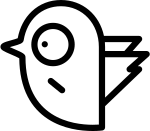

bird


In [14]:
for vec, tgt in train_dl:
    show(c, vec[0])
    print(tgt[0])
    break

In [16]:
### W: legacy 0.1 - dynamic vocab_size
checkpoint = torch.load(f'checkpoints/checkpoint_model_0.1.pth', map_location=device)
vocab_size = len(checkpoint['vocab_tokens'])

model = STTModel(
    vocab_size=vocab_size,
    dim=32,
    seq_len=seq_len,
    n_heads=4,
    n_encoder_layers=1,
    n_decoder_layers=3,
    dropout_p=0.05
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss().to(device)

In [17]:
device.type == "cpu"

True

In [18]:
step = -1
metrics = {'train_loss': [], 'test_loss': []}
save_path = "checkpoints"

# step, metrics = load_checkpoint(model, opt, save_path, 'epoch', 186_500, device)
step, metrics = load_checkpoint(model, opt, save_path, 'model', '0.1', device)
step

1

Epoch: 0, step: 100, loss: 2.091974973678589, test_loss: 1.386257529258728


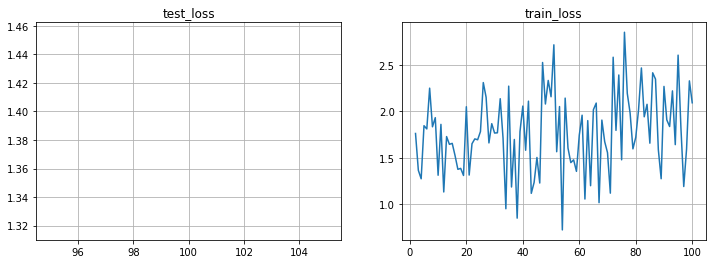

KeyboardInterrupt: 

In [20]:
train(model,
      opt,
      loss_fn,
      train_dl=train_dl,
      test_dl=test_dl,
      device=device,
      metrics=metrics,
      save_path=save_path,
      step=step,
      converter=c,
      epochs=100,
     )

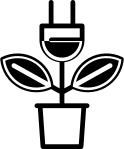

target: gardening leaf
result: flowers


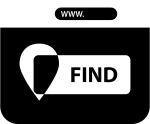

target: browser seo and web
result: train


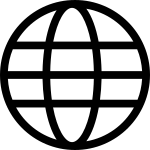

target: globe grid
result: intestine


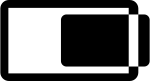

target: battery
result: phone receiver


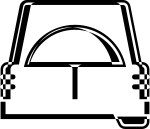

target: bed bedroom
result: server


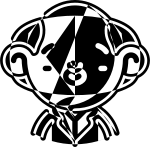

target: clown fun
result: airplane


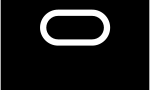

target: box covered
result: text


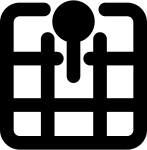

target: vintage joystick
result: computer monitor


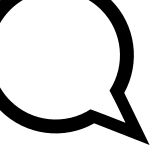

target: round speech bubble with ellipsis
result: circular graphic


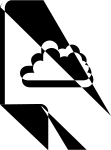

target: cloud computing
result: ironing


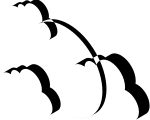

target: sun meteorology
result: lifebuoy


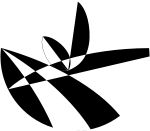

target: farm
result: apple


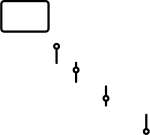

target: settings
result: painting


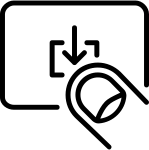

target: tap import
result: block


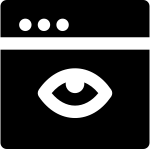

target: browser ui
result: smartphone


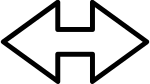

target: resize ui
result: rewind


In [21]:
sample(c, model, test_dl, device=device, p_value=0.5)